<a href="https://colab.research.google.com/github/asanneh/CS109A_2019_GR31_FINAL_PROJECT/blob/master/FinalProject31_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse

# New Section

Helpful guide: https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c. I mounted my google drive and then unzipped the Spotify Data. I think I got everything (CSVs from 0-999). Each CSV is 11 MB, so the unzipped size of the data is 11 GB (not too terrible?). We can always run things on the GPU by going to Runtime > change runtime type > GPU. That should give more space. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#  !unzip -q "/content/drive/My Drive/CS109A project/Spotify.zip" -d "/content/drive/My Drive/CS109A project"

warning [/content/drive/My Drive/CS109A project/Spotify.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #882:  bad zipfile offset (local header sig):  868912
  (attempting to re-compensate)


In [5]:
#look at 1000 playlists from the first file
songs0 = pd.read_csv('/content/drive/My Drive/CS109A project/Songs/songs0.csv')
print(f'dataset shape: {songs0.shape}')
len(songs0['pid'].unique())
print(f'unique playlists: {len(songs0.pid.unique())}')
print(f'unique songs: {len(songs0.track_uri.unique())}')
songs0.head()

dataset shape: (67503, 9)
unique playlists: 1000
unique songs: 34443


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,0,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,0,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,0,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,0,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [0]:
#what identifier should we use
print(f'unique songs by uri: {len(songs0.track_uri.unique())}')
print(f'unique songs by name: {len(songs0.track_name.unique())}')
print('unique artist+track combos (uri):', len(songs0.groupby(['track_uri', 'artist_uri'])))
print('unique artist+track combos (name):', len(songs0.groupby(['track_name', 'artist_name'])))
songs0.isnull().sum()
songs0_nodup = songs0.drop_duplicates(subset = 'track_uri') #drop all duplicated songs

counts = songs0_nodup['track_name'].value_counts() #count up occurences of song names
counts


unique songs by uri: 34443
unique songs by name: 30049
unique artist+track combos (uri): 34443
unique artist+track combos (name): 34250


Silent Night          21
Home                  20
Closer                18
Smile                 16
Hallelujah            16
                      ..
Beauty School          1
Reggae Music Lives     1
Donna Lee              1
Gitana                 1
Guinevere              1
Name: track_name, Length: 30049, dtype: int64

In [0]:
# look at the first 5 unique songs named 'Home' - we have different uris for each of them. 
songs0_nodup.loc[songs0_nodup['track_name']=='Home'][0:5]


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
1750,32,9,Johnnyswim,spotify:track:2BX2njwutbKutDcLVFiqUU,spotify:artist:4igDSX1kgfWbVTDCywcBGm,Home,spotify:album:2y2pzedHjln9MbTHCq99qP,211106,Diamonds
2630,42,130,Billy Crudup,spotify:track:3JWkxuQyYKzdMr5yBHUnWR,spotify:artist:6OKX0ui8juGXVOOW02uCbm,Home,spotify:album:54a0lBXG3n0YEI32pyPwA1,236373,Rudderless (Original Motion Picture Soundtrack)
2643,42,143,Edward Sharpe & The Magnetic Zeros,spotify:track:7w5cxTEzp1rfV3KCy0Bd5N,spotify:artist:7giUHu5pv6YTZgSkxxCcgh,Home,spotify:album:39xrkt8RILtwa9DMyLkv32,303200,Up from Below
6771,108,46,The Piano Guys,spotify:track:6aE6m5NGfzSZtC5gmpo4d3,spotify:artist:0jW6R8CVyVohuUJVcuweDI,Home,spotify:album:5vInnbRSNVuhkF8HpMwVVS,277560,Wonders
9530,146,12,Three Days Grace,spotify:track:11RUCSAgpexhJSMmcuO4h2,spotify:artist:2xiIXseIJcq3nG7C8fHeBj,Home,spotify:album:13topfW33NjnACjnRiZBX7,260680,Three Days Grace


I think URIs are a better way to go here - unique to each song and artist, regardless of name overlaps. Especially with cover songs - could be entirely different styles and belong in different playlists. 

count    1000.00000
mean       67.50300
std        55.00334
min         5.00000
25%        25.00000
50%        50.00000
75%        92.50000
max       245.00000
Name: track_uri, dtype: float64

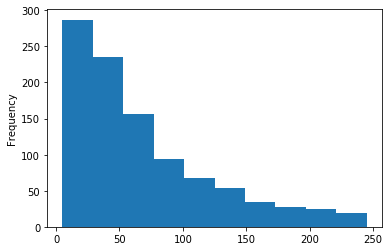

In [0]:
#what is the average length of a playlist
num_songs_in_pl = songs0.groupby(by='pid').count()['track_uri']
num_songs_in_pl.plot(kind = 'hist');

num_songs_in_pl.describe()

I am using the two websites here to figure out how to make a recommender from a sparse matrix:
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://jessesw.com/Rec-System/


In [8]:
#make sparse binary matrix of playlist x uniq song? 0 if song not in playlist, 1 if it is
#play_song_mat = np.zeros([len(songs0.pid.unique()), len(songs0.track_uri.unique())])
#play_song_mat.shape

n_pls = songs0.pid.unique().shape[0]
n_songs = songs0.track_uri.unique().shape[0]

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {float(songs0.shape[0]) /float(n_pls*n_songs) * 100:0.3f}%')

#make sparse matrix
rows = songs0.pid.astype('category').cat.codes # make category codes/indices for each playlist
cols = songs0.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(rows.shape[0]) #1s if song is in playlist

likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs0.groupby(by=['pid', 'track_uri']).count()['track_name'].shape)
likes

Num playlists: 1000
Num unique songs: 34443
Sparsity: 0.196%
(66721,)


<1000x34443 sparse matrix of type '<class 'numpy.float64'>'
	with 66721 stored elements in Compressed Sparse Row format>

In [0]:
!wget -cq  https://cs109a-group31-final-project.s3.amazonaws.com/Spotify.zip 
!unzip -qq Spotify.zip

warning [Spotify.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #882:  bad zipfile offset (local header sig):  868912
  (attempting to re-compensate)


In [0]:
songs_temp = pd.read_csv('/content/Songs/songs100.csv')
print(f'dataset shape: {songs_temp.shape}')
len(songs_temp['pid'].unique())
print(f'unique playlists: {len(songs_temp.pid.unique())}')
print(f'unique songs: {len(songs_temp.track_uri.unique())}')
songs_temp.head()

dataset shape: (68750, 9)
unique playlists: 1000
unique songs: 36685


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,ZAYN,spotify:track:3NdDpSvN911VPGivFlV5d0,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,I Don’t Wanna Live Forever (Fifty Shades Darke...,spotify:album:5MxXY7DbFMUiHFTPUabgJJ,245200,I Don’t Wanna Live Forever (Fifty Shades Darker)
1,0,1,Halsey,spotify:track:1uoL9GX45dTnmrWQ7Ii1Ft,spotify:artist:26VFTg2z8YR0cCuwLzESi2,Not Afraid Anymore,spotify:album:4HLA2Fsva7IJafJrhG5u52,226800,Not Afraid Anymore
2,0,2,Bryson Tiller,spotify:track:43PuMrRfbyyuz4QpZ3oAwN,spotify:artist:2EMAnMvWE2eb56ToJVfCWs,Exchange,spotify:album:6eZdwrhB97A3EYx9QppGfl,194613,T R A P S O U L
3,0,3,PARTYNEXTDOOR,spotify:track:1wZqJM5FGDEl3FjHDxDyQd,spotify:artist:2HPaUgqeutzr3jx5a9WyDV,Come and See Me (feat. Drake),spotify:album:2FXGUAESmG5l9YPrzWPvHI,235477,PARTYNEXTDOOR 3 (P3)
4,0,4,Bryson Tiller,spotify:track:3pXF1nA74528Edde4of9CC,spotify:artist:2EMAnMvWE2eb56ToJVfCWs,Don't,spotify:album:6eZdwrhB97A3EYx9QppGfl,198293,T R A P S O U L
